# Random Ensemble Orchestration - With get STATE


## RL test

Defining the Simulation enviroment

Running the simulation

In [1]:
from stable_baselines3 import PPO
from managers.enviroment_manager import SimulationEnv
#setup_config()

# Create the environment
env = SimulationEnv("ppo")

# Train the agent
model = PPO("MlpPolicy", env, verbose=1, n_steps=1028)
model.learn(total_timesteps=1)

# Save the trained model
model.save("simulation_policy")


Contents of c:\Documents\Aalto Semester 2\ResearchCloud\RL_simulation\initial_sim_config.yaml have been dumped into c:\Documents\Aalto Semester 2\ResearchCloud\RL_simulation\sim_config.yaml.


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\Filippo\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning:

You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.

c:\Users\Filippo\anaconda3\Lib\site-packages\stable_baselines3\ppo\ppo.py:155: UserWarning:

You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1028`, after every 16 untruncated mini-batches, there will be a truncated mini-batch of size 4
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1028 and n_envs=1)

2025-01-30 21:13:32,774:INFO -- Action: Adding a model


Best model: EfficientNetV2S with score: 0.953925925925926
Model 'EfficientNetV2S' successfully added to the target YAML.
STATE:  {'ensemble_state': {'total_energy_consumption': 0.003833157044692698, 'ensemble_size': 4}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.6666666666666666, 'confidence': 0.6261961261431376, 'avg_response_time': 2.0594603368682876, 'max_response_time': 2.097639906766157, 'contribution': 0.6261961261431376}, 'MobileNetV2': {'accuracy': 0.3333333333333333, 'confidence': 0.3252038558324178, 'avg_response_time': 0.03798850443635452, 'max_response_time': 0.06273312378610445, 'contribution': 0.3252038558324178}, 'ResNet50V2': {'accuracy': 0.3333333333333333, 'confidence': 0.33306628465652466, 'avg_response_time': 0.11239522015319425, 'max_response_time': 0.11356434339199893, 'contribution': 0.5182428161303202}, 'ensemble': {'accuracy': 0.6666666666666666, 'confidence': 0.6315773493713803, 'avg_response_time': 2.066676137834479, 'max_response_time': 2.107579664

2025-01-30 21:13:33,568:INFO -- Action: Replacing a model


REWARD:  3.981216764360117
Worst model: ResNet50V2 with score: 0.7573739295908658
Model 'ResNet50V2' successfully removed from the target YAML.
Best model: NASNetLarge with score: 0.942962962962963
Model 'NASNetLarge' successfully added to the target YAML.


2025-01-30 21:13:33,931:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.006499981282645277, 'ensemble_size': 4}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.75, 'confidence': 0.6993517875671387, 'avg_response_time': 2.0384434242357083, 'max_response_time': 2.097639906766157, 'contribution': 0.6993517875671387}, 'MobileNetV2': {'accuracy': 0.5, 'confidence': 0.4043242186307907, 'avg_response_time': 0.03418328594520116, 'max_response_time': 0.06273312378610445, 'contribution': 0.4043242186307907}, 'ResNet50V2': {'accuracy': 0.3333333333333333, 'confidence': 0.33306628465652466, 'avg_response_time': 0.11239522015319425, 'max_response_time': 0.11356434339199893, 'contribution': 0.5182428161303202}, 'ensemble': {'accuracy': 0.75, 'confidence': 0.686435886969169, 'avg_response_time': 2.513960320910566, 'max_response_time': 3.8558128701388275, 'contribution': 0.8602408170700073}, 'EfficientNetV2S': {'accuracy': 1.0, 'confidence': 0.9065342247486115, 'avg_response_time': 1.174986138439253, 'max_res

2025-01-30 21:13:34,129:INFO -- Action: Keeping the ensemble
2025-01-30 21:13:34,335:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.006499981282645277, 'ensemble_size': 4}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8333333333333334, 'confidence': 0.7467025419076284, 'avg_response_time': 2.0466475921893648, 'max_response_time': 2.097639906766157, 'contribution': 0.7467025419076284}, 'MobileNetV2': {'accuracy': 0.6666666666666666, 'confidence': 0.5697048902511597, 'avg_response_time': 0.034315587644186824, 'max_response_time': 0.06273312378610445, 'contribution': 0.5697048902511597}, 'ResNet50V2': {'accuracy': 0.3333333333333333, 'confidence': 0.33306628465652466, 'avg_response_time': 0.11239522015319425, 'max_response_time': 0.11356434339199893, 'contribution': 0.5182428161303202}, 'ensemble': {'accuracy': 0.8333333333333334, 'confidence': 0.7517263723744287, 'avg_response_time': 2.9469039137609836, 'max_response_time': 3.8558128701388275, 'contribution': 0.8803990185260773}, 'EfficientNetV2S': {'accuracy': 1.0, 'confidence': 0.904657244682312, 'av

2025-01-30 21:13:34,838:INFO -- Action: Adding a model


Best model: DenseNet201 with score: 0.8944655883285759
Model 'DenseNet201' successfully added to the target YAML.


2025-01-30 21:13:35,168:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.01131999673746023, 'ensemble_size': 5}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.75, 'confidence': 0.6801784783601761, 'avg_response_time': 2.04924744666364, 'max_response_time': 2.097639906766157, 'contribution': 0.7874964252114296}, 'MobileNetV2': {'accuracy': 0.6666666666666666, 'confidence': 0.5697048902511597, 'avg_response_time': 0.034315587644186824, 'max_response_time': 0.06273312378610445, 'contribution': 0.5697048902511597}, 'ResNet50V2': {'accuracy': 0.3333333333333333, 'confidence': 0.33306628465652466, 'avg_response_time': 0.11239522015319425, 'max_response_time': 0.11356434339199893, 'contribution': 0.5182428161303202}, 'ensemble': {'accuracy': 0.75, 'confidence': 0.6741953591505687, 'avg_response_time': 3.9980068650768255, 'max_response_time': 7.166437547586726, 'contribution': 0.8915005102753639}, 'EfficientNetV2S': {'accuracy': 0.8333333333333334, 'confidence': 0.7542326251665751, 'avg_response_time'

2025-01-30 21:13:35,455:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.016804851811249164, 'ensemble_size': 6}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.6666666666666666, 'confidence': 0.604603091875712, 'avg_response_time': 2.0579397443212515, 'max_response_time': 2.1274781255821438, 'contribution': 0.8012618886099921}, 'MobileNetV2': {'accuracy': 0.6666666666666666, 'confidence': 0.5697048902511597, 'avg_response_time': 0.034315587644186824, 'max_response_time': 0.06273312378610445, 'contribution': 0.5697048902511597}, 'ResNet50V2': {'accuracy': 0.3333333333333333, 'confidence': 0.33306628465652466, 'avg_response_time': 0.11239522015319425, 'max_response_time': 0.11356434339199893, 'contribution': 0.5182428161303202}, 'ensemble': {'accuracy': 0.6666666666666666, 'confidence': 0.5992847636893944, 'avg_response_time': 4.349002249947533, 'max_response_time': 7.166437547586726, 'contribution': 0.900258911980523}, 'EfficientNetV2S': {'accuracy': 0.7142857142857143, 'confidence': 0.64648510

2025-01-30 21:13:36,240:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.01131999673746023, 'ensemble_size': 5}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.7272727272727273, 'confidence': 0.6624751470305703, 'avg_response_time': 2.066888011795311, 'max_response_time': 2.1274781255821438, 'contribution': 0.8233777989040721}, 'MobileNetV2': {'accuracy': 0.6666666666666666, 'confidence': 0.5697048902511597, 'avg_response_time': 0.034315587644186824, 'max_response_time': 0.06273312378610445, 'contribution': 0.5697048902511597}, 'ResNet50V2': {'accuracy': 0.3333333333333333, 'confidence': 0.33306628465652466, 'avg_response_time': 0.11239522015319425, 'max_response_time': 0.11356434339199893, 'contribution': 0.5182428161303202}, 'ensemble': {'accuracy': 0.7272727272727273, 'confidence': 0.6520676269675746, 'avg_response_time': 4.850488292335701, 'max_response_time': 7.166437547586726, 'contribution': 0.9125434756278992}, 'EfficientNetV2S': {'accuracy': 0.7777777777777778, 'confidence': 0.70485203

2025-01-30 21:13:36,642:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.01131999673746023, 'ensemble_size': 5}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.75, 'confidence': 0.6783370027939478, 'avg_response_time': 2.0790476920900933, 'max_response_time': 2.212804175332695, 'contribution': 0.8258311003446579}, 'MobileNetV2': {'accuracy': 0.6666666666666666, 'confidence': 0.5697048902511597, 'avg_response_time': 0.034315587644186824, 'max_response_time': 0.06273312378610445, 'contribution': 0.5697048902511597}, 'ResNet50V2': {'accuracy': 0.3333333333333333, 'confidence': 0.33306628465652466, 'avg_response_time': 0.11239522015319425, 'max_response_time': 0.11356434339199893, 'contribution': 0.5182428161303202}, 'ensemble': {'accuracy': 0.75, 'confidence': 0.6638710154427423, 'avg_response_time': 5.04223867306894, 'max_response_time': 7.166437547586726, 'contribution': 0.9113147755463918}, 'EfficientNetV2S': {'accuracy': 0.8, 'confidence': 0.7153694927692413, 'avg_response_time': 1.14932616291

2025-01-30 21:13:37,287:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.01100840203748216, 'ensemble_size': 4}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.7857142857142857, 'confidence': 0.7023821515696389, 'avg_response_time': 2.0768365214211997, 'max_response_time': 2.212804175332695, 'contribution': 0.8288056637559619}, 'MobileNetV2': {'accuracy': 0.6666666666666666, 'confidence': 0.5697048902511597, 'avg_response_time': 0.034315587644186824, 'max_response_time': 0.06273312378610445, 'contribution': 0.5697048902511597}, 'ResNet50V2': {'accuracy': 0.3333333333333333, 'confidence': 0.33306628465652466, 'avg_response_time': 0.11239522015319425, 'max_response_time': 0.11356434339199893, 'contribution': 0.5182428161303202}, 'ensemble': {'accuracy': 0.7857142857142857, 'confidence': 0.6864164057232085, 'avg_response_time': 5.3380639754453805, 'max_response_time': 7.166437547586726, 'contribution': 0.9109121944223132}, 'EfficientNetV2S': {'accuracy': 0.8333333333333334, 'confidence': 0.7440943

2025-01-30 21:13:37,648:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.01100840203748216, 'ensemble_size': 4}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8, 'confidence': 0.7180562098821004, 'avg_response_time': 2.0752565547371513, 'max_response_time': 2.212804175332695, 'contribution': 0.8360514879226685}, 'MobileNetV2': {'accuracy': 0.6666666666666666, 'confidence': 0.5697048902511597, 'avg_response_time': 0.034315587644186824, 'max_response_time': 0.06273312378610445, 'contribution': 0.5697048902511597}, 'ResNet50V2': {'accuracy': 0.3333333333333333, 'confidence': 0.33306628465652466, 'avg_response_time': 0.11239522015319425, 'max_response_time': 0.11356434339199893, 'contribution': 0.5182428161303202}, 'ensemble': {'accuracy': 0.8, 'confidence': 0.700321745938725, 'avg_response_time': 5.456896133480437, 'max_response_time': 7.166437547586726, 'contribution': 0.9126842498779297}, 'EfficientNetV2S': {'accuracy': 0.8461538461538461, 'confidence': 0.7589299449553857, 'avg_response_time': 

2025-01-30 21:13:38,343:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.006465659633972781, 'ensemble_size': 3}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8235294117647058, 'confidence': 0.7429851328625399, 'avg_response_time': 2.0721993324018007, 'max_response_time': 2.212804175332695, 'contribution': 0.8470986134865705}, 'MobileNetV2': {'accuracy': 0.6666666666666666, 'confidence': 0.5697048902511597, 'avg_response_time': 0.034315587644186824, 'max_response_time': 0.06273312378610445, 'contribution': 0.5697048902511597}, 'ResNet50V2': {'accuracy': 0.3333333333333333, 'confidence': 0.33306628465652466, 'avg_response_time': 0.11239522015319425, 'max_response_time': 0.11356434339199893, 'contribution': 0.5182428161303202}, 'ensemble': {'accuracy': 0.8235294117647058, 'confidence': 0.7247390321072411, 'avg_response_time': 5.462287648791204, 'max_response_time': 7.167284091928981, 'contribution': 0.9152598977088928}, 'EfficientNetV2S': {'accuracy': 0.8666666666666667, 'confidence': 0.7810007

2025-01-30 21:13:38,550:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.01100840203748216, 'ensemble_size': 4}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8333333333333334, 'confidence': 0.7526290350490146, 'avg_response_time': 2.063621309806171, 'max_response_time': 2.212804175332695, 'contribution': 0.8509584334161546}, 'MobileNetV2': {'accuracy': 0.6666666666666666, 'confidence': 0.5697048902511597, 'avg_response_time': 0.034315587644186824, 'max_response_time': 0.06273312378610445, 'contribution': 0.5697048902511597}, 'ResNet50V2': {'accuracy': 0.3333333333333333, 'confidence': 0.33306628465652466, 'avg_response_time': 0.11239522015319425, 'max_response_time': 0.11356434339199893, 'contribution': 0.5182428161303202}, 'ensemble': {'accuracy': 0.8333333333333334, 'confidence': 0.7346557580762441, 'avg_response_time': 5.556312313328336, 'max_response_time': 7.167284091928981, 'contribution': 0.9156563878059387}, 'EfficientNetV2S': {'accuracy': 0.875, 'confidence': 0.7890559434890747, 'avg

2025-01-30 21:13:39,115:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.01100840203748216, 'ensemble_size': 4}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8421052631578947, 'confidence': 0.759945505543759, 'avg_response_time': 2.061300474163387, 'max_response_time': 2.212804175332695, 'contribution': 0.8530996724178916}, 'MobileNetV2': {'accuracy': 0.6666666666666666, 'confidence': 0.5697048902511597, 'avg_response_time': 0.034315587644186824, 'max_response_time': 0.06273312378610445, 'contribution': 0.5697048902511597}, 'ResNet50V2': {'accuracy': 0.3333333333333333, 'confidence': 0.33306628465652466, 'avg_response_time': 0.11239522015319425, 'max_response_time': 0.11356434339199893, 'contribution': 0.5182428161303202}, 'ensemble': {'accuracy': 0.8421052631578947, 'confidence': 0.740137939704092, 'avg_response_time': 5.6383330933079, 'max_response_time': 7.167284091928981, 'contribution': 0.9143924713134766}, 'EfficientNetV2S': {'accuracy': 0.8823529411764706, 'confidence': 0.7914231945486

2025-01-30 21:13:39,449:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.01100840203748216, 'ensemble_size': 4}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.85, 'confidence': 0.7681053876876831, 'avg_response_time': 2.059568685298967, 'max_response_time': 2.212804175332695, 'contribution': 0.8566018462181091}, 'MobileNetV2': {'accuracy': 0.6666666666666666, 'confidence': 0.5697048902511597, 'avg_response_time': 0.034315587644186824, 'max_response_time': 0.06273312378610445, 'contribution': 0.5697048902511597}, 'ResNet50V2': {'accuracy': 0.3333333333333333, 'confidence': 0.33306628465652466, 'avg_response_time': 0.11239522015319425, 'max_response_time': 0.11356434339199893, 'contribution': 0.5182428161303202}, 'ensemble': {'accuracy': 0.85, 'confidence': 0.7490179139375688, 'avg_response_time': 5.714648060824684, 'max_response_time': 7.167284091928981, 'contribution': 0.915608698129654}, 'EfficientNetV2S': {'accuracy': 0.8888888888888888, 'confidence': 0.7992142968707614, 'avg_response_time':

2025-01-30 21:13:40,058:INFO -- Action: Adding a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.01100840203748216, 'ensemble_size': 4}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8181818181818182, 'confidence': 0.7399813587015326, 'avg_response_time': 2.0597407228937716, 'max_response_time': 2.212804175332695, 'contribution': 0.8204326846382834}, 'MobileNetV2': {'accuracy': 0.6666666666666666, 'confidence': 0.5697048902511597, 'avg_response_time': 0.034315587644186824, 'max_response_time': 0.06273312378610445, 'contribution': 0.5697048902511597}, 'ResNet50V2': {'accuracy': 0.3333333333333333, 'confidence': 0.33306628465652466, 'avg_response_time': 0.11239522015319425, 'max_response_time': 0.11356434339199893, 'contribution': 0.5182428161303202}, 'ensemble': {'accuracy': 0.8636363636363636, 'confidence': 0.7548209594054657, 'avg_response_time': 5.845871013670632, 'max_response_time': 7.167284091928981, 'contribution': 0.8740752772851423}, 'EfficientNetV2S': {'accuracy': 0.9, 'confidence': 0.8022825181484222, 'avg_

2025-01-30 21:13:40,842:INFO -- Action: Replacing a model


STATE:  {'ensemble_state': {'total_energy_consumption': 0.006465659633972781, 'ensemble_size': 3}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.84, 'confidence': 0.7611502480506896, 'avg_response_time': 2.0581600180395974, 'max_response_time': 2.212804175332695, 'contribution': 0.8319474148750305}, 'MobileNetV2': {'accuracy': 0.6666666666666666, 'confidence': 0.5697048902511597, 'avg_response_time': 0.034315587644186824, 'max_response_time': 0.06273312378610445, 'contribution': 0.5697048902511597}, 'ResNet50V2': {'accuracy': 0.3333333333333333, 'confidence': 0.33306628465652466, 'avg_response_time': 0.11239522015319425, 'max_response_time': 0.11356434339199893, 'contribution': 0.5182428161303202}, 'ensemble': {'accuracy': 0.88, 'confidence': 0.7698650352954866, 'avg_response_time': 5.868199180186901, 'max_response_time': 7.191269455549127, 'contribution': 0.8797481441497803}, 'EfficientNetV2S': {'accuracy': 0.9130434782608695, 'confidence': 0.8152715978415116, 'avg_response_tim

2025-01-30 21:13:41,160:INFO -- Action: Keeping the ensemble


STATE:  {'ensemble_state': {'total_energy_consumption': 0.0055445715225166566, 'ensemble_size': 3}, 'model_states': {'InceptionResNetV2': {'accuracy': 0.8461538461538461, 'confidence': 0.7580495797670804, 'avg_response_time': 2.0300676687137718, 'max_response_time': 2.212804175332695, 'contribution': 0.8261237786366389}, 'MobileNetV2': {'accuracy': 0.6666666666666666, 'confidence': 0.5697048902511597, 'avg_response_time': 0.034315587644186824, 'max_response_time': 0.06273312378610445, 'contribution': 0.5697048902511597}, 'ResNet50V2': {'accuracy': 0.3333333333333333, 'confidence': 0.33306628465652466, 'avg_response_time': 0.11239522015319425, 'max_response_time': 0.11356434339199893, 'contribution': 0.5182428161303202}, 'ensemble': {'accuracy': 0.8846153846153846, 'confidence': 0.762479900626036, 'avg_response_time': 5.788980931135307, 'max_response_time': 7.191269455549127, 'contribution': 0.8720860183238983}, 'EfficientNetV2S': {'accuracy': 0.9166666666666666, 'confidence': 0.8015753

KeyError: 'ml_inference'

# Check results

In [2]:
import pandas as pd

# Define the path to the CSV file
csv_file_path = "results/reinf_learning_inference/ensemble_inference.csv"

print("action policy: random action - with Bounds\n")
# Read the CSV file
df = pd.read_csv(csv_file_path)
print("number of inferences: ", df.size)

# Calculate average accuracy for all labels
average_accuracy_all = df["accuracy"].mean()

# Calculate average accuracy for a specific label
average_accuracy_per_label = df.groupby("label")["accuracy"].mean()

# Print the results
print(f"Average accuracy across all labels: {average_accuracy_all:.4f}")
print(f"Average accuracy for all labels: ") 
print(average_accuracy_per_label)

action policy: random action - with Bounds

number of inferences:  5150
Average accuracy across all labels: 0.8942
Average accuracy for all labels: 
label
n01440764    0.951691
n01443537    0.958333
n01484850    0.850242
n01491361    0.803030
n01494475    0.900990
Name: accuracy, dtype: float64


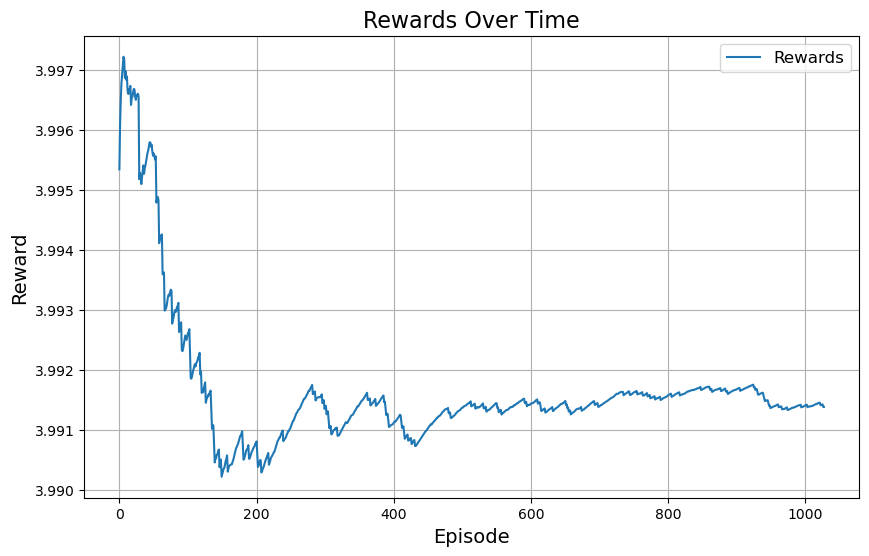

In [3]:

import matplotlib.pyplot as plt

# Assuming env.visualization_manager.reward_list is a list of rewards
def plot_rewards(reward_list):
    plt.figure(figsize=(10, 6))
    plt.plot(reward_list, label="Rewards", linestyle='-')
    plt.title("Rewards Over Time", fontsize=16)
    plt.xlabel("Episode", fontsize=14)
    plt.ylabel("Reward", fontsize=14)
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.show()

# Example usage:
if hasattr(env, 'visualization_manager') and hasattr(env.visualization_manager, 'reward_list'):
    plot_rewards(env.visualization_manager.reward_list)
else:
    print("reward_list not found in env.visualization_manager.")

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

def read_reward_column(csv_file_path, required_data):

    # Load the CSV file
    data = pd.read_csv(csv_file_path)

    # Check if 'reward' column exists

    # Read the 'reward' column
    reward_column = data[required_data]


    # Plot the reward column
    plt.figure(figsize=(10, 6))
    plt.plot(reward_column, linestyle='-', color='b')
    plt.title(f'{required_data} plot')
    plt.xlabel('Index')
    plt.ylabel('Reward')
    plt.grid(True)
    plt.show()

    return reward_column


# Example usage
csv_file_path = "results/reinforcement_learning.csv"  # Replace with your actual file path


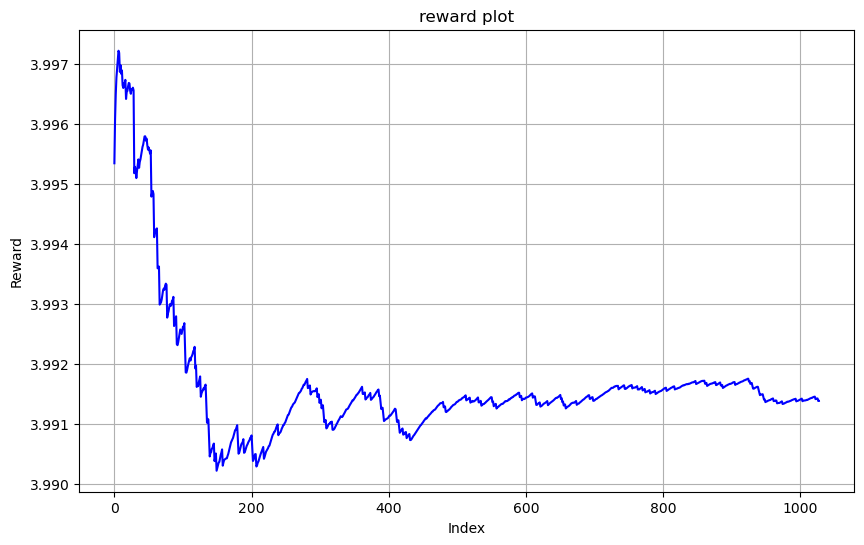

0       3.995340
1       3.996072
2       3.996487
3       3.996767
4       3.996917
          ...   
1023    3.991419
1024    3.991423
1025    3.991425
1026    3.991383
1027    3.991384
Name: reward, Length: 1028, dtype: float64

In [ ]:
read_reward_column(csv_file_path, "reward")

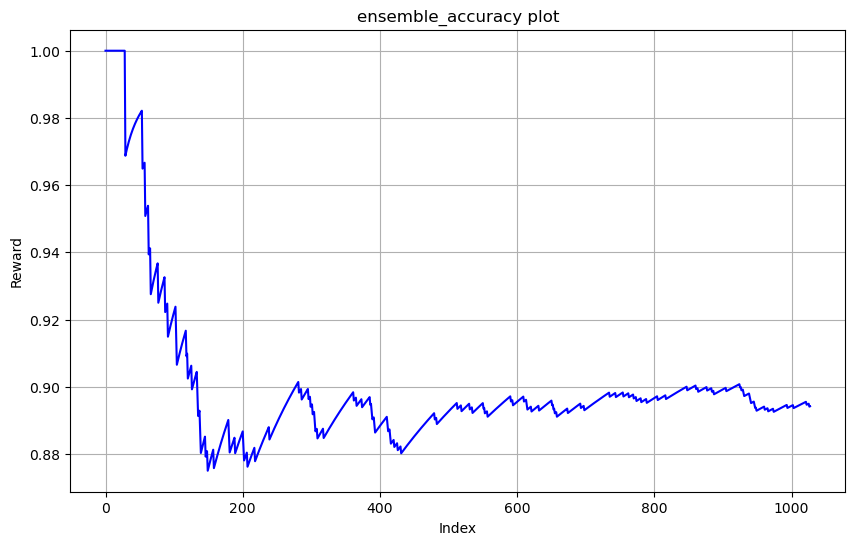

0       1.000000
1       1.000000
2       1.000000
3       1.000000
4       1.000000
          ...   
1023    0.894737
1024    0.894839
1025    0.894942
1026    0.894072
1027    0.894175
Name: ensemble_accuracy, Length: 1028, dtype: float64

In [6]:
read_reward_column(csv_file_path, "ensemble_accuracy")

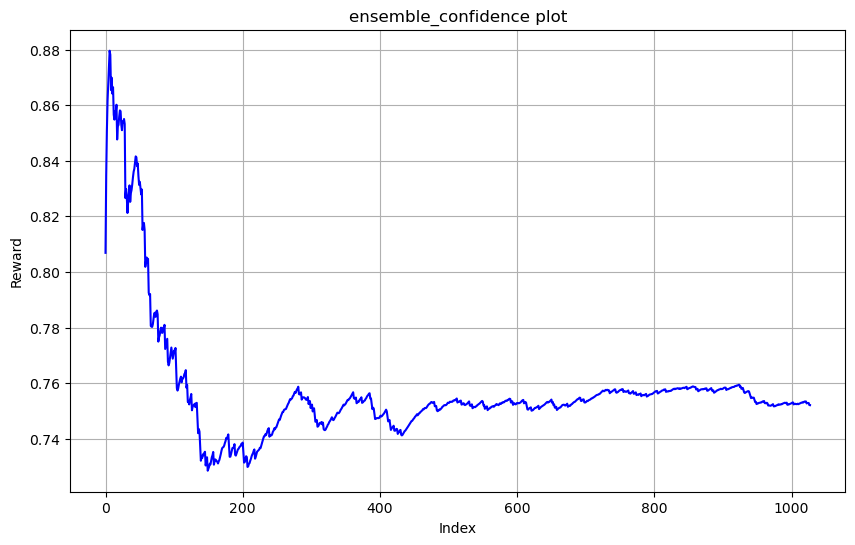

0       0.806864
1       0.834519
2       0.850643
3       0.861666
4       0.867648
          ...   
1023    0.752818
1024    0.752870
1025    0.752840
1026    0.752108
1027    0.752071
Name: ensemble_confidence, Length: 1028, dtype: float64

In [7]:
read_reward_column(csv_file_path, "ensemble_confidence")

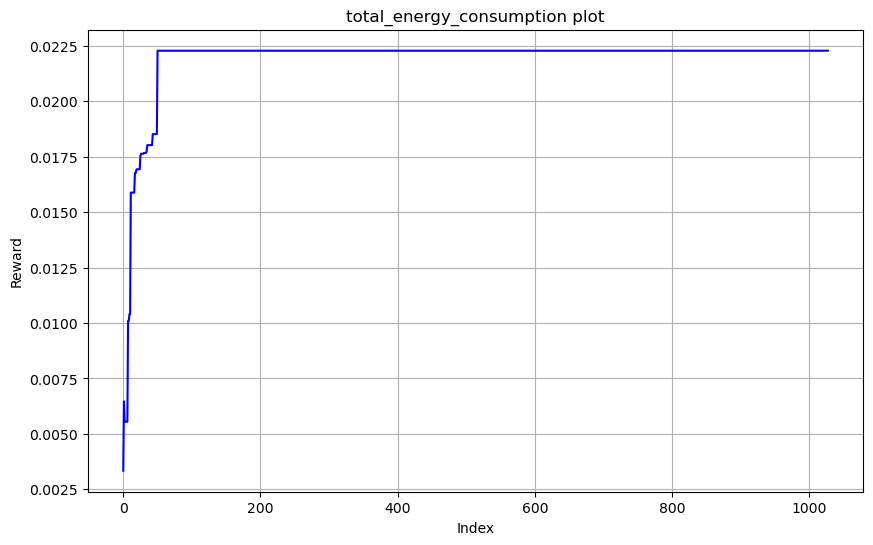

0       0.003336
1       0.006466
2       0.005545
3       0.005545
4       0.005545
          ...   
1023    0.022284
1024    0.022284
1025    0.022284
1026    0.022284
1027    0.022284
Name: total_energy_consumption, Length: 1028, dtype: float64

In [ ]:
read_reward_column(csv_file_path, "total_energy_consumption")